# Welcome to Time Series! #

In this micro-course you'll learn an invaluble skill: how to predict the future!

![Image](../images/header.png)

After completing this micro-course, you'll be able to:
- Forecast the popularity of a search term with linear regression.
- Predict the daily page-views of a website with [Prophet](https://facebook.github.io/prophet/).
- Estimate market demand for a ride-sharing company with XGBoost.
- Discover highly-profitable customers with a Markov model. And,
- Build a deep learning model with Keras to predict the weather.

You'll be prepared for this micro-course if you know how to [construct a machine learning model](https://www.kaggle.com/dansbecker/your-first-machine-learning-model), [manipulate dataframes with Pandas](https://www.kaggle.com/residentmario/indexing-selecting-assigning), and [use seaborn to explore your data](https://www.kaggle.com/alexisbcook/hello-seaborn). You'll have a leg up if you've done some work on the [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) competition, but we'll review what we need as we go.

# What is a Time Series? #

A **time series** is simply a sequence of observations together with the times those observations occured. The times provide an **index** to the observations. Usually, the observations will have been made over some fixed time interval, like every hour or every month.

Time series are very common. They occur virtually anywhere data is collected sequentially over time. Time series are used to analyze such things as: economic growth, volatility in financial markets, EEG brainwave signals, natural disasters like earthquakes and volcanoes.

What characterizes time series is that their observations are **sequentially dependent**. How the observations are ordered in time is important. This is different from ordinary data sets where the rows can be taken in any order without affecting the analysis.

Time series analysis is mostly about working with the extra information that this time dependence provides. Over this micro-course, you'll learn about a number of models especially designed for time series and what to do to make sure you get the most from your data.

# Your Problem #

Let's suppose you work for a book publisher. Your boss has heard that data science has been getting popular. She thinks there could be a market opportunity for a new textbook, but she wants to know if this popularity will continue. She asks you to describe how interest in data science has been trending over the past five years, and to make a forecast one year into the future.

You turn to [Google Trends](https://trends.google.com/trends/). With Google Trends you can get a report of how popular a search term has been over time. For your analysis, you decide to investigate the term "data science", and you retrieve a CSV file for the period of January 25, 2015 to January 25, 2020, with observations taken weekly. (Click 
[here](https://trends.google.com/trends/explore?date=2015-01-25%202020-01-25&geo=US&q=data%20science) for an interactive graph of this data set.)

First, let's load the data into a Pandas DataFrame.

In [1]:
import pandas as pd
pd.plotting.register_matplotlib_converters()

# Read the file into a variable 'datascience'
# Parse the 'Week' column as a date and set it as the index
datascience = pd.read_csv('../data/datascience.csv', parse_dates=['Week'], index_col='Week')

And let's get a quick overview.

In [2]:
# View the first five weeks of the dataset
datascience.head()

,Interest
Week,
2015-01-25,34
2015-02-01,31
2015-02-08,32
2015-02-15,26
2015-02-22,29


The numbers in the `Interest` column represent the popularity for that week relative to when the term was most popular over the time observed. Google says: "A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means there was not enough data for this term."

It's good to look at some summary statistics, as well.

In [3]:
datascience.describe()

,Interest
count,261.000000
mean,57.831418
std,19.399701
min,26.000000
25%,40.000000
50%,58.000000
75%,73.000000
max,100.000000


# Plotting Time Series #

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

Time series are commonly represented as [line charts](https://www.kaggle.com/alexisbcook/line-charts), with the index along the x-axis. A line chart emphasizes the ordered nature of a time series.

You can quickly plot a time series with the `DataFrame.plot` method. For time series, `pandas` will create a line chart by default.

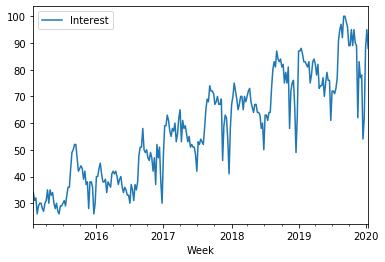

In [5]:
datascience.plot();

For more detailed plots, we'll turn to [seaborn](https://seaborn.pydata.org/index.html). You may have learned about `seaborn` in a [previous micro-course](https://www.kaggle.com/learn/data-visualization). `seaborn` is a powerful and flexible supplement to `matplotlib` for statistical visualization.

First let's set up the plotting environment.

In [6]:
import seaborn as sns

# With 'sns.set' you can set default parameters for your plots
# With no arguments, it sets the parameters to the seaborn 'darkgrid' style
sns.set()

# 'plt.rc' modifies default matplotlib properties
# You can also pass these as a dictionary to 'sns.set'
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize='x-large')
plt.rc('xtick', labelsize='large')
plt.rc('ytick', labelsize='large')
plt.rc('legend', fontsize='large')

Now we can get a better visualization of our time series. You can add method calls to `plt` to add or modify features of your plot.

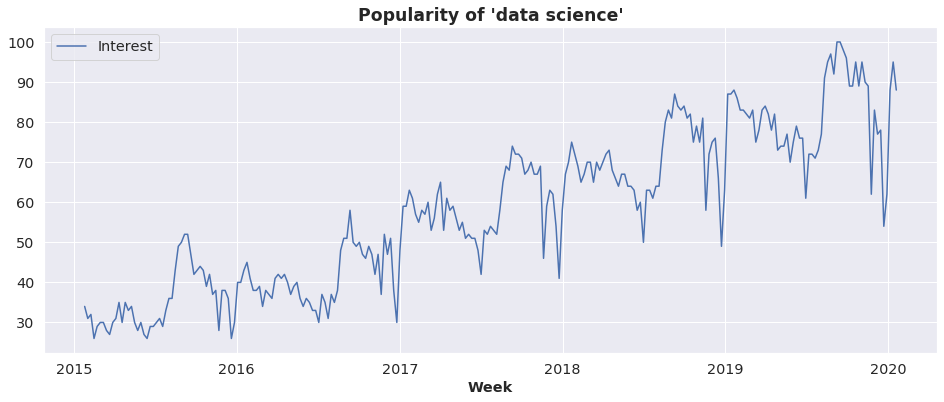

In [7]:
plt.figure(figsize=(16,6))
plt.title("Popularity of 'data science'")
# Use 'sns.lineplot' when plotting time series
sns.lineplot(data=datascience);

# Fitting a Trend-Line #

Because time series are temporally dependent, there ought to be some predictive information in the time index itself. We should be able to treat the time index as a feature.

The time-dependence in a time series can occur in many ways. One of the most important is through a **trend**, meaning a steady rise or fall in the series. Whenever a series is constantly increasing or constantly decreasing on the average, we can capture this trend with a line.

For our first model in this micro-course, we will fit a **linear trend-line** using [simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression). Our trend-line model will fit a least-squares line with `Interest` as the target and `Week` as the feature. See the next figure for an example of a linear trend-line.

| ![Time Series with a Linear Trend](../images/linear-trend.png) |
|:--:|
| *A Time Series with a Linear Trend and a Trend-Line* |

# Prepare Data #

We will follow the usual procedure of evaluating our model with a training set and a validation set. There are two issues we must address, however, before splitting the data.

First, the least-squares algorithm requires numeric features. Since the `Week` variable is a date type, we can't construct the model on it directly. Instead, we represent it with a **time dummy**. The time dummy is just an enumeration of the periods in the time series, beginning at 1. The time dummy for `Week` will go: 1, 2, 3, ..., 261, one for each week.

In [8]:
# Construct the "time dummy": 1, 2, 3, ...
datascience['Week'] = range(1, len(datascience.index) + 1)

datascience.head()

,Interest,Week
Week,,
2015-01-25,34,1
2015-02-01,31,2
2015-02-08,32,3
2015-02-15,26,4
2015-02-22,29,5


In [9]:
datascience.tail()

,Interest,Week
Week,,
2019-12-22,54,257
2019-12-29,62,258
2020-01-05,88,259
2020-01-12,95,260
2020-01-19,88,261


Second, we need to be careful when splitting the data into training set and validation set. Ordinarily, it is good practice to shuffle your data set before splitting to ensure the splits are statistically independent. Time series models, however, rely on the data *not* being independent. This is what makes time series special. We must make sure when splitting to **preserve the original order**.

Also, in forecasting, we use information about the past to predict the future. We want to make sure, therefore, that all of the validation data occurs *after* the training data. With time series, **the validation set should always be later in time than the training set**.

In [10]:
from sklearn.model_selection import train_test_split

# Split the data into a training set and a validation set
# The order of the observations is important, so don't shuffle
# And have the training set come before the validation set
train_data, val_data = train_test_split(datascience, test_size = 0.2, shuffle = False)

Now let's check that we get what we expected.

In [11]:
train_data.tail()

,Interest,Week
Week,,
2018-12-16,66,204
2018-12-23,49,205
2018-12-30,63,206
2019-01-06,87,207
2019-01-13,87,208


In [12]:
val_data.head()

,Interest,Week
Week,,
2019-01-20,88,209
2019-01-27,86,210
2019-02-03,83,211
2019-02-10,83,212
2019-02-17,82,213


# Define and Fit the Model #

Many of our models for this micro-course will come from the `statsmodels` library. `statsmodels` is like the `sklearn` of time series.

The easiest way to get started with `statsmodels` is through its [formula interface](https://www.statsmodels.org/stable/example_formulas.html). Formulas in `statsmodels` work the same way as formulas in R. Instead of passing in our variables as arrays (like in `sklearn`), in `statsmodels` we can specify the regression relationship with a special kind of string and let `statsmodels` create the arrays for us.

For simple linear regression, we write the formula as: `'target ~ feature'`.

In [13]:
import statsmodels.formula.api as smf

# Fit an ordinary least-squares model using the formula interface
datascience_model = smf.ols('Interest ~ Week', train_data).fit()
# Look at the fitted coefficients of the least-squares line
datascience_model.params

Intercept    27.049749
Week          0.235906
dtype: float64

The `Intercept` parameter tells us the y-intercept for the line and the `Week` parameter tells us the slope. The coefficients say: "Predict about 27 points of Interest for the first week, and about 0.24 more points for every week that goes by."

# Evaluate the Model #

We'll evaluate our predictions with [root-mean-square error](https://en.wikipedia.org/wiki/Root-mean-square_deviation) (RMSE). In future lessons, we'll learn other metrics often used for time series.

In [14]:
from sklearn.metrics import mean_squared_error

# In-sample predictions and RMSE
train_predictions = datascience_model.predict(train_data)
rmse_train = mean_squared_error(train_data.Interest, train_predictions, squared=False)
# Out-of-sample predictions (the forecast) and RMSE
val_predictions = datascience_model.predict(val_data)
rmse_val = mean_squared_error(val_data.Interest, val_predictions, squared=False)

print("RMSE of fitted predictions:")
print(rmse_train)
print()
print("RMSE of forecast predictions:")
print(rmse_val)

RMSE of fitted predictions:
7.58820232858924

RMSE of forecast predictions:
10.468300409850144


The error increased by about 38% from the training set to the validation set. This suggests that our model is having some trouble generalizing. Something changed in the time series during the forecast period.

# Interpret Predictions #

Let's make a plot of our predictions to get a better idea of what's going on.

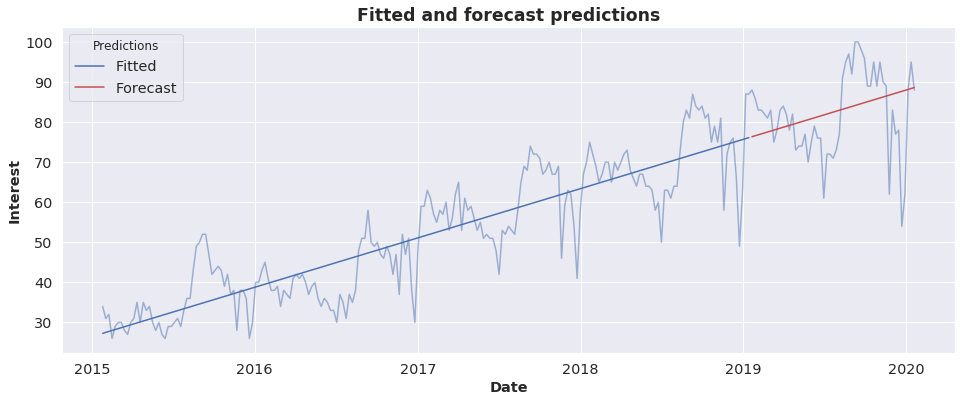

In [15]:
plt.figure(figsize=(16,6))
sns.lineplot(data=datascience.Interest, alpha=0.5)
sns.lineplot(data=train_predictions, label='Fitted', color='b')
sns.lineplot(data=val_predictions, label='Forecast', color='r');
plt.title("Fitted and forecast predictions")
plt.xlabel("Date")
plt.ylabel("Interest")
plt.legend(title="Predictions")
plt.show()

You can see that the popularity of "data science" tends to fall in the summer and winter and rise Spring and Fall. (Students on break from school?) It's apparent that there is information we aren't using that could help us make our predictions better. Later we'll see models that can make use of this kind of seasonal pattern.

# Conclusion #

The defining property of time series is their dependence on a temporal order. This temporal dependence is both a useful source of information and also a strong constraint.

In this lesson we looked at a number important topics: trends and seasons in time series, the importance of preserving the temporal order, how a model can make use of this ordering. These topics are central to the understanding of time series modeling and they will recur throughout this course.

# Your Turn #

Now you know how to make forecasts using a linear trend-line. When you're ready, move on to the first exercise!